In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import utils
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

In [2]:
anr_tag = 'FOAK'
wacc = utils.WACC
cambium_scenario = 'MidCase'
year = 2024
results_path = f'./results/raw_results_anr_{anr_tag}_h2_wacc_{str(wacc)}.xlsx'
clean_save_path = f'./results/clean_results_anr_{anr_tag}_h2_wacc_{str(wacc)}.xlsx'


In [3]:
save_fig_path = './results/ammonia_anr_'+anr_tag+'_h2'

In [4]:
df = pd.read_excel(results_path, sheet_name='ammonia')
df.sort_values(by=['Breakeven price ($/MMBtu)'], inplace=True)
df.reset_index(inplace=True)
df.drop(columns=['index'], inplace=True)
df.columns

Index(['id', 'state', 'Ammonia capacity (tNH3/year)', 'H2 Dem. (kg/day)',
       'Aux Elec Dem. (MWe)', 'Net Revenues ($/year)',
       'H2 PTC Revenues ($/year)', 'Net Revenues with H2 PTC ($/year)', 'PEM',
       'Alkaline', 'HTSE', 'Ann. CO2 emissions (kgCO2eq/year)',
       'ANR CAPEX ($/year)', 'H2 CAPEX ($/year)', 'ANR O&M ($/year)',
       'H2 O&M ($/year)', 'Conversion costs ($/year)',
       'Avoided NG costs ($/year)', 'Breakeven price ($/MMBtu)', 'ANR CRF',
       'Depl. ANR Cap. (MWe)', 'Depl H2 Cap. (MWe)', 'Surplus ANR Cap. (MWe)',
       'Net Annual Revenues ($/MWe/y)',
       'Net Annual Revenues with H2 PTC ($/MWe/y)', 'ANR type',
       '# ANR modules'],
      dtype='object')

In [5]:
anr_param = pd.read_excel('ANRs.xlsx', sheet_name=anr_tag)

### Cumulative number of viable ammonia plants and ANR modules

In [6]:
anr_thermal_power = anr_param[['Power in MWt', 'Power in MWe', 'Reactor']]
df = df.merge(anr_thermal_power, how='inner', left_on=['ANR type'], right_on=['Reactor'])
df.sort_values(by=['Breakeven price ($/MMBtu)'], inplace=True)
df['Deployed Power (MWt)'] = df['Power in MWt']*df['# ANR modules']
df['Deployed Power (MWe)'] = df['Power in MWe']*df['# ANR modules']
df['ANR Nameplate Capacity (GWe)'] = df['Deployed Power (MWe)'].cumsum()/1000
df['Cum h2 dem (t/day)'] =df['H2 Dem. (kg/day)'].cumsum()/1000
df['Cum h2 dem (%)'] = 100*df['H2 Dem. (kg/day)'].cumsum()/df['H2 Dem. (kg/day)'].sum()
df.tail(10)

,id,state,Ammonia capacity (tNH3/year),H2 Dem. (kg/day),Aux Elec Dem. (MWe),Net Revenues ($/year),H2 PTC Revenues ($/year),Net Revenues with H2 PTC ($/year),PEM,Alkaline,...,ANR type,# ANR modules,Power in MWt,Power in MWe,Reactor,Deployed Power (MWt),Deployed Power (MWe),ANR Nameplate Capacity (GWe),Cum h2 dem (t/day),Cum h2 dem (%)
24,Co_E.,IL,350000,483970.750863,0.198107,-2.129818e+08,5.299480e+08,2.617430e+08,0,0,...,PBR-HTGR,6,200,80.0,PBR-HTGR,1200,480.0,22.4220,23624.686510,94.564676
25,Dy_Ch,WY,175000,241985.375431,0.099053,-1.105024e+08,2.649740e+08,1.286229e+08,0,0,...,PBR-HTGR,3,200,80.0,PBR-HTGR,600,240.0,22.6620,23866.671885,95.533293
26,Ko_Fo,IA,340000,470143.015124,0.192447,-2.190542e+08,5.148066e+08,2.477147e+08,0,0,...,PBR-HTGR,6,200,80.0,PBR-HTGR,1200,480.0,23.1420,24336.814901,97.415177
27,LS_Ch,AL,170000,235071.507562,0.096223,-1.115455e+08,2.574033e+08,1.215659e+08,0,0,...,PBR-HTGR,3,200,80.0,PBR-HTGR,600,240.0,23.3820,24571.886408,98.356119
28,Au_Gr,TN,60000,82966.414434,0.033961,-4.007471e+07,9.084822e+07,4.219991e+07,0,0,...,PBR-HTGR,1,200,80.0,PBR-HTGR,200,80.0,23.4620,24654.852823,98.688216
29,U._Mo,TN,60000,82966.414434,0.033961,-4.007471e+07,9.084822e+07,4.219991e+07,0,0,...,PBR-HTGR,1,200,80.0,PBR-HTGR,200,80.0,23.5420,24737.819237,99.020313
30,Ne_Ge,NE,90000,124449.621650,0.050942,-6.053232e+07,1.362723e+08,6.302414e+07,0,0,...,iMSR,1,300,141.0,iMSR,300,141.0,23.6830,24862.268859,99.518459
31,Gr_Cr,IA,32000,44248.754365,0.018113,-3.748706e+07,4.845239e+07,6.444122e+06,0,0,...,Micro,5,20,6.7,Micro,100,33.5,23.7165,24906.517613,99.695578
32,Ch_El,CA,25000,34569.339347,0.014150,-3.005769e+07,3.785343e+07,3.418630e+06,0,0,...,Micro,4,20,6.7,Micro,80,26.8,23.7433,24941.086952,99.833951
33,Sh_Go,GA,30000,41483.207217,0.016981,-3.708146e+07,4.542411e+07,3.629641e+06,0,0,...,Micro,5,20,6.7,Micro,100,33.5,23.7768,24982.570160,100.000000


In [7]:
df['Viable ANR modules count'] = df['# ANR modules'].cumsum()
df.reset_index(inplace=True)
df.drop(columns=['index'], inplace=True)
df['Viable ANR ammonia plants count'] = df.index+1
df.tail(10)

,id,state,Ammonia capacity (tNH3/year),H2 Dem. (kg/day),Aux Elec Dem. (MWe),Net Revenues ($/year),H2 PTC Revenues ($/year),Net Revenues with H2 PTC ($/year),PEM,Alkaline,...,Power in MWt,Power in MWe,Reactor,Deployed Power (MWt),Deployed Power (MWe),ANR Nameplate Capacity (GWe),Cum h2 dem (t/day),Cum h2 dem (%),Viable ANR modules count,Viable ANR ammonia plants count
24,Co_E.,IL,350000,483970.750863,0.198107,-2.129818e+08,5.299480e+08,2.617430e+08,0,0,...,200,80.0,PBR-HTGR,1200,480.0,22.4220,23624.686510,94.564676,172,25
25,Dy_Ch,WY,175000,241985.375431,0.099053,-1.105024e+08,2.649740e+08,1.286229e+08,0,0,...,200,80.0,PBR-HTGR,600,240.0,22.6620,23866.671885,95.533293,175,26
26,Ko_Fo,IA,340000,470143.015124,0.192447,-2.190542e+08,5.148066e+08,2.477147e+08,0,0,...,200,80.0,PBR-HTGR,1200,480.0,23.1420,24336.814901,97.415177,181,27
27,LS_Ch,AL,170000,235071.507562,0.096223,-1.115455e+08,2.574033e+08,1.215659e+08,0,0,...,200,80.0,PBR-HTGR,600,240.0,23.3820,24571.886408,98.356119,184,28
28,Au_Gr,TN,60000,82966.414434,0.033961,-4.007471e+07,9.084822e+07,4.219991e+07,0,0,...,200,80.0,PBR-HTGR,200,80.0,23.4620,24654.852823,98.688216,185,29
29,U._Mo,TN,60000,82966.414434,0.033961,-4.007471e+07,9.084822e+07,4.219991e+07,0,0,...,200,80.0,PBR-HTGR,200,80.0,23.5420,24737.819237,99.020313,186,30
30,Ne_Ge,NE,90000,124449.621650,0.050942,-6.053232e+07,1.362723e+08,6.302414e+07,0,0,...,300,141.0,iMSR,300,141.0,23.6830,24862.268859,99.518459,187,31
31,Gr_Cr,IA,32000,44248.754365,0.018113,-3.748706e+07,4.845239e+07,6.444122e+06,0,0,...,20,6.7,Micro,100,33.5,23.7165,24906.517613,99.695578,192,32
32,Ch_El,CA,25000,34569.339347,0.014150,-3.005769e+07,3.785343e+07,3.418630e+06,0,0,...,20,6.7,Micro,80,26.8,23.7433,24941.086952,99.833951,196,33
33,Sh_Go,GA,30000,41483.207217,0.016981,-3.708146e+07,4.542411e+07,3.629641e+06,0,0,...,20,6.7,Micro,100,33.5,23.7768,24982.570160,100.000000,201,34


### Avoided carbon emissions

In [8]:
ammonia_demand_df = pd.read_excel('./h2_demand_ammonia_us_2022.xlsx', sheet_name='processed')
df = df.merge(ammonia_demand_df, on='id')
ratio_co2_to_nh3 = 2.30 # tCO2eq/tNH3
df['NG path GHG (tCO2/year)'] = df.apply(lambda x:x['Capacity (tNH3/year)']*2.30, axis=1)

In [9]:
df['Ann. avoided CO2 emissions (MMT-CO2/year)'] = (df['NG path GHG (tCO2/year)'] - (df['Ann. CO2 emissions (kgCO2eq/year)']/1e3))/1e6
df['Viable avoided emissions (MMT-CO2/year)'] = df['Ann. avoided CO2 emissions (MMT-CO2/year)'].cumsum()
df[['Breakeven price ($/MMBtu)', 'Viable avoided emissions (MMT-CO2/year)']].tail(50)


,Breakeven price ($/MMBtu),Viable avoided emissions (MMT-CO2/year)
0,20.600471,8.540105
1,20.656438,10.742927
2,21.065262,13.130181
3,21.071284,14.095908
4,21.212002,14.584146
5,21.232675,16.244418
6,21.378282,16.960557
7,21.464289,17.904597
8,21.680785,19.065694
9,21.875788,19.988046


### Comparison against RES

In [10]:
df[['Breakeven price ($/MMBtu)', 'Cum h2 dem (%)']]

,Breakeven price ($/MMBtu),Cum h2 dem (%)
0,20.600471,21.780041
1,20.656438,27.398018
2,21.065262,33.486467
3,21.071284,35.949521
4,21.212002,37.194886
5,21.232675,41.429125
6,21.378282,43.255659
7,21.464289,45.663364
8,21.680785,48.624564
9,21.875788,50.976919


In [11]:
res_be = pd.read_csv('./results/res_be_ammonia.csv', index_col='RES')
def find_be_h2_demand(df, percentage):
  indleft = df['Cum h2 dem (%)'].sub(percentage).abs().idxmin()
  be = df['Breakeven price ($/MMBtu)'][indleft]
  return be
for percent in [10, 25, 50, 75, 90]:
  res_be.loc[str(percent), 'Breakeven price ($/MMBtu)'] = find_be_h2_demand(df, percent)
res_be

,Breakeven price ($/MMBtu)
RES,
Grid PEM,87.789310
Wind unsubsidized,110.147433
Wind subsidized,93.748720
Solar PEC,124.313727
Solar PV-E,127.576608
SMR 89% CCUS,33.125966
10,20.600471
25,20.656438
50,21.875788


In [12]:
sheetn= 'ammonia'
excelf = './results/res_be_comparison.xlsx'
try:
  with pd.ExcelFile(excelf, engine='openpyxl') as xls:
    with pd.ExcelWriter(excelf, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
      res_be.to_excel(writer, sheet_name=sheetn)
except FileNotFoundError:
  res_be.to_excel(excelf, sheet_name=sheetn)

### Compute Revenues from Electricity Cogeneration

In [14]:
df = utils.compute_cogen(df, surplus_cap_col_name='Surplus ANR Cap. (MWe)', state_col_name='state', \
                         cambium_scenario=cambium_scenario, year = year)
df['Net Revenues with H2 PTC with elec ($/year)'] = df['Net Revenues with H2 PTC ($/year)']+df['Electricity revenues ($/y)']

### Save

In [15]:
df_clean = df[["id", 'state', 'Capacity (tNH3/year)', 'H2 Dem. (kg/day)', 'HTSE', 'ANR type', '# ANR modules', \
               'Net Revenues ($/year)', 'Ann. avoided CO2 emissions (MMT-CO2/year)', 'Breakeven price ($/MMBtu)', \
                'Electricity revenues ($/y)','Net Revenues with H2 PTC with elec ($/year)',\
                'Viable avoided emissions (MMT-CO2/year)', 'Cum h2 dem (%)', 'Net Revenues with H2 PTC ($/year)']]
df_clean['H2 Dem. (kg/day)'] /=1e3

df_clean['HTSE'] = df_clean['HTSE'].apply(lambda x: int(x))

df_clean['H2 Dem. (kg/day)'] = df_clean['H2 Dem. (kg/day)'].apply(lambda x:np.round(x,1))

df_clean['Avoided cost of CO2 ($/ton)'] = df_clean['Net Revenues ($/year)']/(1e6*df_clean['Ann. avoided CO2 emissions (MMT-CO2/year)'])
df_clean['Avoided cost of CO2 ($/ton)'] = df_clean['Avoided cost of CO2 ($/ton)'].apply(lambda x:np.round(np.abs(x),1))

df_clean['Net Revenues ($/year)'] = df_clean['Net Revenues ($/year)'].apply(lambda x: np.round(x/1e6,1))

df_clean['Ann. avoided CO2 emissions (MMT-CO2/year)']= df_clean['Ann. avoided CO2 emissions (MMT-CO2/year)'].apply(lambda x: np.round(x,1))

df_clean['Breakeven price ($/MMBtu)'] = df_clean['Breakeven price ($/MMBtu)'].apply(lambda x : np.round(x,1))

df_clean.rename(columns={'H2 Dem. (kg/day)': 'Demand (MT H2/day)',
                         'Net Rev. ($/year)': 'Net Rev. (M$/year)', 
                         'ANR type': 'ANR', 
                         '# ANR modules': '#'}, inplace=True)


In [16]:
sheet_name = 'ammonia'
excel_file = clean_save_path
try:
# Load the existing Excel file
  with pd.ExcelFile(excel_file, engine='openpyxl') as xls:
      with pd.ExcelWriter(excel_file, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
              df.to_excel(writer, sheet_name=sheet_name)
except FileNotFoundError:
    # If the file doesn't exist, create a new one and write the DataFrame to it
    df.to_excel(excel_file, sheet_name=sheet_name)

### Plots

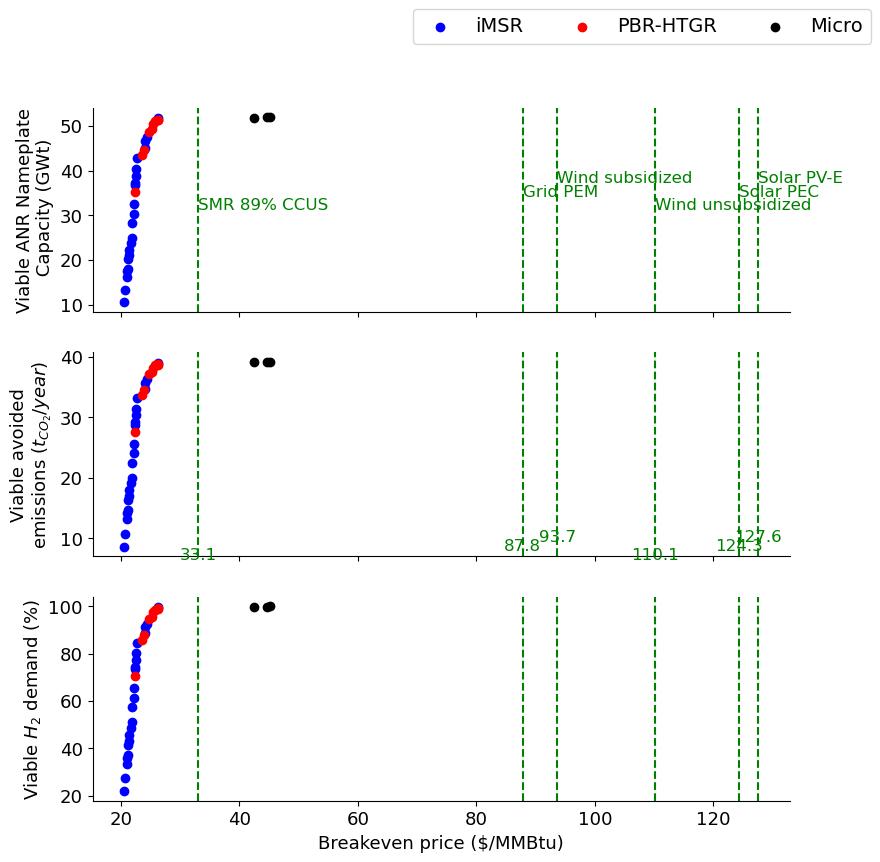

In [55]:
#Use latex font
#plt.rcParams['text.usetex'] = True
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['font.size'] = 13

# Create subplots
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(9, 9))

# Get unique ANR types and assign colors
anr_types = df['ANR type'].unique()

colors = ['blue', 'red', 'black']  # Adjust the colors according to the unique ANR types
# Initialize empty handles for legend
handles = []
# Plotting the data as scatter plots with different colors for each ANR type
labels = {'ANR Nameplate Capacity (GWt)': 'Viable ANR Nameplate\n Capacity (GWt)',
            'Viable avoided emissions (MMT-CO2/year)': 'Viable avoided\n'r'emissions ($t_{CO_2}/year$)',
            'Cum h2 dem (%)':r'Viable $H_2$ demand (%)'}
for i, col in enumerate(['ANR Nameplate Capacity (GWt)', 'Viable avoided emissions (MMT-CO2/year)', 'Cum h2 dem (%)']):
    for anr_type, color in zip(anr_types, colors):
        subset = df[df['ANR type'] == anr_type]
        axs[i].scatter(subset['Breakeven price ($/MMBtu)'], subset[col], color=color, label=f'{anr_type}')
    axs[i].set_ylabel(labels[col])

    # Remove the top and right spines
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)


    # Adding vertical lines
    res_be = pd.read_csv('./results/res_be_ammonia.csv')
    res_be.sort_values(by='Breakeven price ($/MMBtu)', inplace=True)
    res_be['Breakeven price ($/MMBtu)'] = res_be.apply(lambda x:np.round(x['Breakeven price ($/MMBtu)'],1), axis=1)

    #ng_vertical_lines = [6.4, 13, 40]
    #ng_labels = ['US NG\navg 2022', 'CA NG\ndelivered 2022', 'EU NG\n 2022']
    res_vert_lines = list(res_be['Breakeven price ($/MMBtu)'])
    #for line in ng_vertical_lines:
     #   axs[i].axvline(x=line, linestyle='--', color='grey')
    for l,line in enumerate(res_vert_lines):
        axs[i].axvline(x=line, linestyle='--',color='green')


res_labels = res_be['RES']
count = 0
for x, label in zip(res_vert_lines, res_labels):
    axs[0].text(x, (axs[0].get_ylim()[1]+axs[0].get_ylim()[0])/2+3*np.mod(count,3), label, fontsize=12, color='green')
    axs[1].text(x, axs[1].get_ylim()[0]+1.5*np.mod(count,3)+1.5, str(x), color='green', fontsize=12, va='top',ha='center')
    count+=1


# Setting the title and labels
plt.xlabel('Breakeven price ($/MMBtu)')


# Add a common legend for all subplots
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', ncol=len(anr_types))
#fig.tight_layout()
#plt.show()
plt.savefig(save_fig_path+'.png')

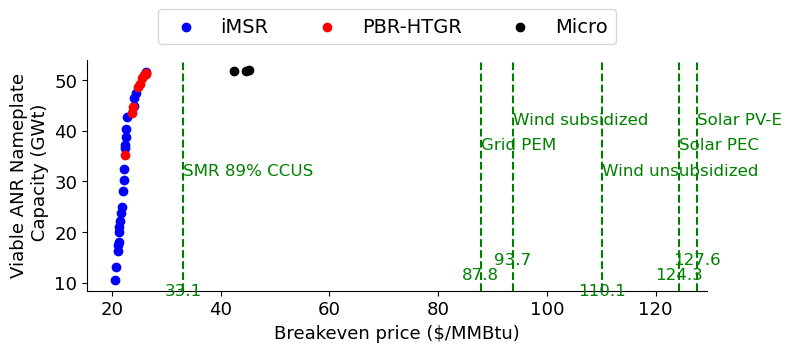

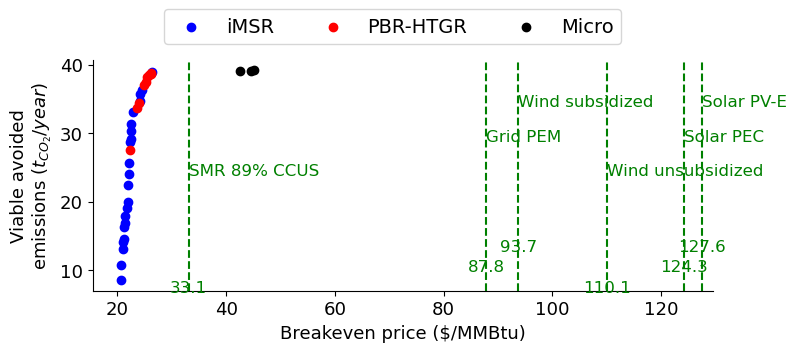

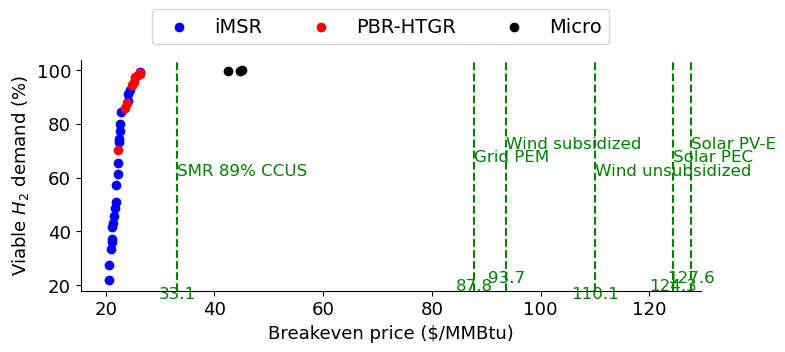

In [56]:
#Use latex font
#plt.rcParams['text.usetex'] = True
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['font.size'] = 13
labels = {'ANR Nameplate Capacity (GWt)': ['Viable ANR Nameplate\n Capacity (GWt)', 'capacity'],
            'Viable avoided emissions (MMT-CO2/year)': ['Viable avoided\n'r'emissions ($t_{CO_2}/year$)', 'emission'],
            'Cum h2 dem (%)':[r'Viable $H_2$ demand (%)', 'h2_demand']}

def plot_against_be(df, col_name, y_label, save_label):
    anr_types = df['ANR type'].unique()
    colors = ['blue', 'red', 'black'] 
    fig, axs = plt.subplots(figsize=(8, 3))
    for anr_type, color in zip(anr_types, colors):
        subset = df[df['ANR type'] == anr_type]
        axs.scatter(subset['Breakeven price ($/MMBtu)'], subset[col_name], color=color, label=f'{anr_type}')
    axs.set_ylabel(y_label)
    axs.spines['top'].set_visible(False)
    axs.spines['right'].set_visible(False)

    # Adding vertical lines and labels for competing RES 
    res_be = pd.read_csv('./results/res_be_ammonia.csv')
    res_be.sort_values(by='Breakeven price ($/MMBtu)', inplace=True)
    res_be['Breakeven price ($/MMBtu)'] = res_be.apply(lambda x:np.round(x['Breakeven price ($/MMBtu)'],1), axis=1)
    res_vert_lines = list(res_be['Breakeven price ($/MMBtu)'])
    for l,line in enumerate(res_vert_lines):
        axs.axvline(x=line, linestyle='--',color='green')
        res_labels = res_be['RES']
    count = 0
    for x, label in zip(res_vert_lines, res_labels):
        axs.text(x, (axs.get_ylim()[1]+axs.get_ylim()[0])/2+5*np.mod(count,3), label, fontsize=12, color='green')
        axs.text(x, axs.get_ylim()[0]+3*np.mod(count,3)+1.5, str(x), color='green', fontsize=12, va='top',ha='center')
        count+=1
        # Setting the title and labels
    axs.set_xlabel('Breakeven price ($/MMBtu)')
    handles, labels = axs.get_legend_handles_labels()
    fig.legend(handles, labels,  bbox_to_anchor=(.5,1.08),loc='upper center', ncol=len(anr_types))

    fig.savefig(save_fig_path+'_'+save_label+'.png', bbox_inches='tight')

for col_name, label_list in labels.items():
    plot_against_be(df, col_name, y_label=label_list[0], save_label=label_list[1])
